In [6]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.image as mpimg
import random

In [2]:
train_dir = "DATASET/TRAIN/"
test_dir = "DATASET/TEST/"

In [3]:
for folder in ['TRAIN', 'TEST']:
    for label in ['O', 'R']:
        count = len(os.listdir(f"DATASET/{folder}/{label}"))
        print(f"{folder}/{label}: {count} images")

TRAIN/O: 9999 images
TRAIN/R: 9999 images
TEST/O: 1401 images
TEST/R: 1112 images


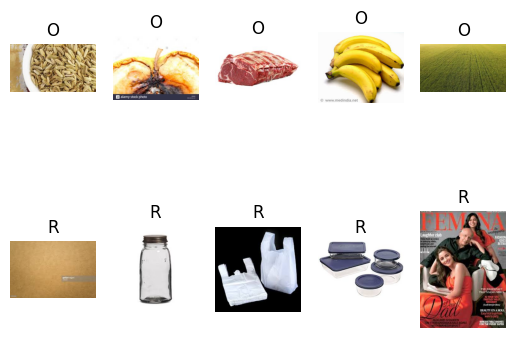

In [8]:
base_path = "DATASET/TRAIN"
labels = ['O', 'R']

for i, label in enumerate(labels):
    folder = os.path.join(base_path, label)
    files = os.listdir(folder)
    
    # Ambil 5 gambar acak
    sample_images = random.sample(files, 5)
    
    for j, img_name in enumerate(sample_images):
        img_path = os.path.join(folder, img_name)
        img = mpimg.imread(img_path)
        
        plt.subplot(2, 5, i * 5 + j + 1)
        plt.imshow(img)
        plt.title(f"{label}")
        plt.axis("off")

plt.show()


In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

Found 16000 images belonging to 2 classes.
Found 3998 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


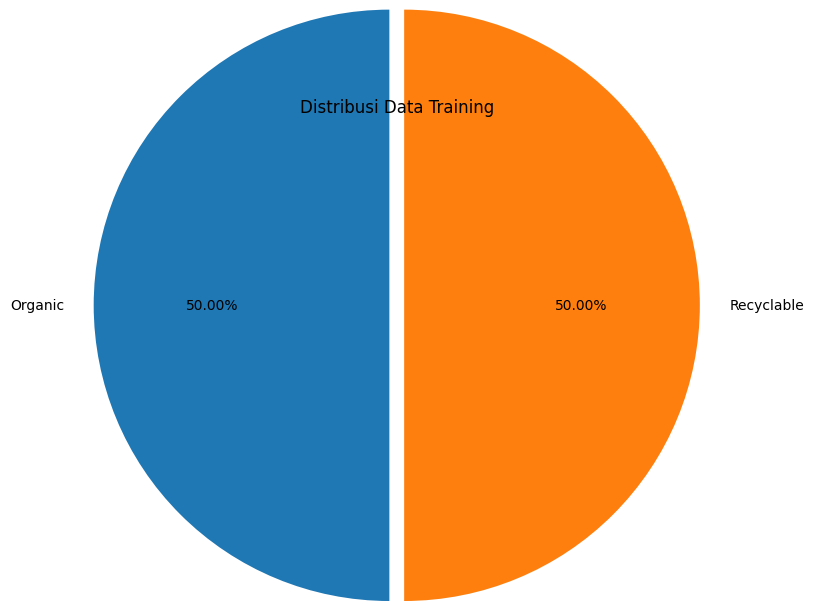

In [12]:
labels = ['Organic', 'Recyclable']
label_counts = [len(os.listdir(os.path.join(train_dir, 'O'))),
                len(os.listdir(os.path.join(train_dir, 'R')))]

plt.pie(
    label_counts,
    labels=labels,
    autopct='%0.2f%%',
    startangle=90,
    explode=[0.05, 0.05],
    radius=2
)
plt.title("Distribusi Data Training")
plt.show()

In [13]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.3),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=5,         
    restore_best_weights=True,  
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, patience=2, 
    min_lr=1e-5)

In [15]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop, reduce_lr] 
)

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 113s 225ms/step - accuracy: 0.8030 - loss: 0.4501 - val_accuracy: 0.7909 - val_loss: 0.4303 - learning_rate: 0.0010
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 112s 224ms/step - accuracy: 0.8282 - loss: 0.4049 - val_accuracy: 0.8007 - val_loss: 0.4010 - learning_rate: 0.0010
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 111s 223ms/step - accuracy: 0.8438 - loss: 0.3726 - val_accuracy: 0.8192 - val_loss: 0.3944 - learning_rate: 0.0010
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 117s 235ms/step - accuracy: 0.8497 - loss: 0.3620 - val_accuracy: 0.8262 - val_loss: 0.3908 - learning_rate: 0.0010
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 136s 272ms/step - accuracy: 0.8601 - loss: 0.3427 - val_accuracy: 0.8242 - val_loss: 0.3757 - learning_rate: 0.0010
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 140s 279ms/step - accuracy: 0.8629 - loss: 0.3366 - val_accuracy: 0.8234 - val_loss: 0.3925 - learning_rate: 0.0010
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 130s 260ms/step - accura

In [16]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nAkurasi Data Test: {test_acc * 100:.2f}%")

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8926 - loss: 0.2912

Akurasi Data Test: 89.26%


In [17]:
model.save('waste_classifier_model.h5')
print("\nModel tersimpan sebagai 'waste_classifier_model.h5'")


Model tersimpan sebagai 'waste_classifier_model.h5'


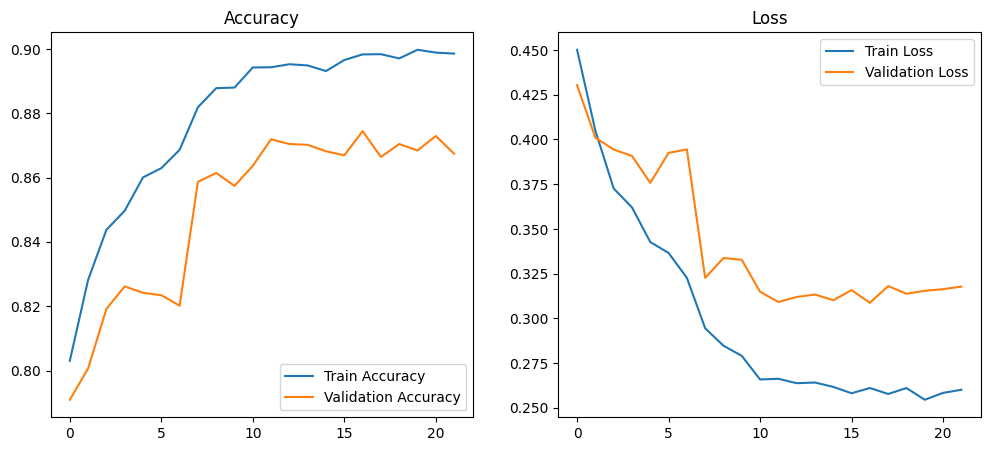

In [18]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()